<a href="https://colab.research.google.com/github/charlottejocelynne/Tugas/blob/main/IndoBERT-finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install datasets

In [ ]:
from datasets import DatasetDict, Dataset

In [ ]:
import pandas as pd
import numpy as np
import io

train_df = pd.read_csv('/content/undersampled_dataset_1_train.csv')
test_df = pd.read_csv('/content/undersampled_dataset_1_test.csv')
valid_df = pd.read_csv('/content/undersampled_dataset_1_validation.csv')

In [ ]:
from datasets import Dataset, DatasetDict

# Konversi ke Hugging Face Dataset
train_ds = Dataset.from_pandas(train_df)
valid_ds = Dataset.from_pandas(valid_df)
test_ds = Dataset.from_pandas(test_df)

# Gabungkan menjadi DatasetDict
dataset = DatasetDict({
    'train': train_ds,
    'validation': valid_ds,
    'test': test_ds
})


In [ ]:
from datasets import Dataset, DatasetDict

# Konversi ke Hugging Face Dataset
train_ds = Dataset.from_pandas(train_df)
valid_ds = Dataset.from_pandas(valid_df)
test_ds = Dataset.from_pandas(test_df)

# Gabungkan menjadi DatasetDict
dataset = DatasetDict({
    'train': train_ds,
    'validation': valid_ds,
    'test': test_ds
})


In [ ]:
print("Distribusi label di train:")
print(train_df['label'].value_counts())

print("\nDistribusi label di validation:")
print(valid_df['label'].value_counts())

print("\nDistribusi label di test:")
print(test_df['label'].value_counts())


Distribusi label di train:
label
1    913
0    913
Name: count, dtype: int64

Distribusi label di validation:
label
0    195
1    195
Name: count, dtype: int64

Distribusi label di test:
label
0    197
1    197
Name: count, dtype: int64


# Load Model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

In [ ]:
model_path = "indobenchmark/indobert-base-p2"

tokenizer = AutoTokenizer.from_pretrained(model_path)

id2label = {0: "Fakta", 1: "Hoaks"}
label2id = {"Fakta": 0, "Hoaks": 1}
model = AutoModelForSequenceClassification.from_pretrained(model_path,
                                                           num_labels=2,
                                                           id2label=id2label,
                                                           label2id=label2id,)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Freeze beberapa layer awal IndoBERT
for name, param in model.bert.named_parameters():
    # Membekukan layer 0-8, misalnya
    if "encoder.layer." in name:
        layer_num = int(name.split("encoder.layer.")[1].split(".")[0])
        if layer_num < 8:
            param.requires_grad = False  # Bekukan layer awal
        else:
            param.requires_grad = True   # Hanya train layer akhir
    else:
        param.requires_grad = True  # Selalu latih layer non-encoder (misalnya output layer)


In [ ]:
for name, param in model.named_parameters():
   print(name, param.requires_grad)

bert.embeddings.word_embeddings.weight True
bert.embeddings.position_embeddings.weight True
bert.embeddings.token_type_embeddings.weight True
bert.embeddings.LayerNorm.weight True
bert.embeddings.LayerNorm.bias True
bert.encoder.layer.0.attention.self.query.weight False
bert.encoder.layer.0.attention.self.query.bias False
bert.encoder.layer.0.attention.self.key.weight False
bert.encoder.layer.0.attention.self.key.bias False
bert.encoder.layer.0.attention.self.value.weight False
bert.encoder.layer.0.attention.self.value.bias False
bert.encoder.layer.0.attention.output.dense.weight False
bert.encoder.layer.0.attention.output.dense.bias False
bert.encoder.layer.0.attention.output.LayerNorm.weight False
bert.encoder.layer.0.attention.output.LayerNorm.bias False
bert.encoder.layer.0.intermediate.dense.weight False
bert.encoder.layer.0.intermediate.dense.bias False
bert.encoder.layer.0.output.dense.weight False
bert.encoder.layer.0.output.dense.bias False
bert.encoder.layer.0.output.LayerNor

# Preprocess Data

In [ ]:
def preprocess_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=512,  # Batas panjang token maksimal
        padding="max_length"  # Mengisi padding hingga max_length
    )

In [ ]:
tokenized_data = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/1826 [00:00<?, ? examples/s]

Map:   0%|          | 0/390 [00:00<?, ? examples/s]

Map:   0%|          | 0/394 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorWithPadding

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Evaluasi

In [ ]:
pip install evaluate

In [ ]:
import evaluate

In [ ]:
import os
# Disable WandB
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# load metrics
accuracy = evaluate.load("accuracy")
auc_score = evaluate.load("roc_auc")

def compute_metrics(eval_pred):
    # get predictions
    predictions, labels = eval_pred

    # apply softmax to get probabilities
    probabilities = np.exp(predictions) / np.exp(predictions).sum(-1, keepdims=True)
    # use probabilities of the positive class for ROC AUC
    positive_class_probs = probabilities[:, 1]
    # compute auc
    auc = np.round(auc_score.compute(prediction_scores=positive_class_probs, references=labels)['roc_auc'],3)

    # predict most probable class
    predicted_classes = np.argmax(predictions, axis=1)
    # compute accuracy
    acc = np.round(accuracy.compute(predictions=predicted_classes, references=labels)['accuracy'],3)

    return {"Accuracy": acc, "AUC": auc}

# Train Model

In [ ]:
!pip install transformers datasets

In [ ]:
# hyperparameters
lr = 1e-5
batch_size = 32
num_epochs = 5

training_args = TrainingArguments(
    output_dir="Indobert-news-classifier_teacher",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

<ipython-input-47-25805d4bc91c>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Auc
1,0.454600,0.220077,0.931000,0.984000
2,0.194000,0.137271,0.949000,0.989000
3,0.134500,0.127879,0.952000,0.990000
4,0.110300,0.127684,0.947000,0.990000
5,0.093300,0.129264,0.949000,0.990000


TrainOutput(global_step=290, training_loss=0.19733598478909198, metrics={'train_runtime': 817.0463, 'train_samples_per_second': 11.174, 'train_steps_per_second': 0.355, 'total_flos': 2402203935436800.0, 'train_loss': 0.19733598478909198, 'epoch': 5.0})

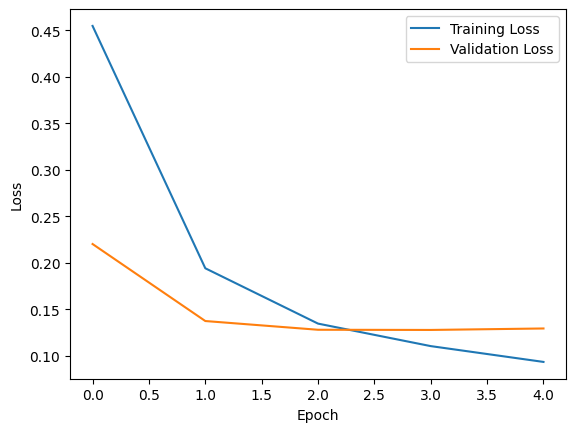

In [ ]:
import matplotlib.pyplot as plt

# Extract loss from log history
training_loss = [log["loss"] for log in trainer.state.log_history if "loss" in log]
validation_loss = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]

# Plotting
plt.plot(training_loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
model.save_pretrained("Indobert-political-news-classifier")
tokenizer.save_pretrained("Indobert-political-news-classifier_teacher")

('Indobert-political-news-classifier_teacher/tokenizer_config.json',
 'Indobert-political-news-classifier_teacher/special_tokens_map.json',
 'Indobert-political-news-classifier_teacher/vocab.txt',
 'Indobert-political-news-classifier_teacher/added_tokens.json',
 'Indobert-political-news-classifier_teacher/tokenizer.json')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Mendapatkan label asli dari data uji
y_true = tokenized_data["validation"]["label"]

In [ ]:
# Melakukan prediksi pada data uji
predictions = trainer.predict(tokenized_data["validation"])
y_pred = predictions.predictions.argmax(axis=1)

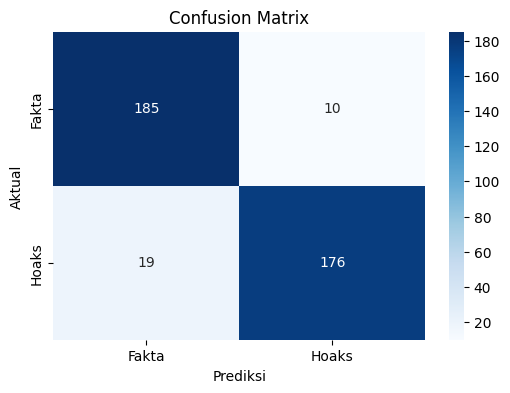

In [ ]:
# 1. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fakta", "Hoaks"], yticklabels=["Fakta", "Hoaks"])
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# 2. Classification Report
print(classification_report(y_true, y_pred, target_names=["Fakta", "Hoaks"]))

              precision    recall  f1-score   support

       Fakta       0.91      0.95      0.93       195
       Hoaks       0.95      0.90      0.92       195

    accuracy                           0.93       390
   macro avg       0.93      0.93      0.93       390
weighted avg       0.93      0.93      0.93       390



In [ ]:
# 3. ROC AUC Score
y_proba = predictions.predictions[:, 1]  # Probabilitas untuk kelas 1 (Hoaks)
print("ROC AUC Score:", roc_auc_score(y_true, y_proba))

ROC AUC Score: 0.9856147271531887


In [ ]:
# Evaluasi model pada dataset uji
eval_result = trainer.evaluate()
print("Hasil Evaluasi:", eval_result)

Hasil Evaluasi: {'eval_loss': 0.12768369913101196, 'eval_Accuracy': 0.947, 'eval_AUC': 0.99, 'eval_runtime': 12.6273, 'eval_samples_per_second': 31.202, 'eval_steps_per_second': 1.03, 'epoch': 5.0}


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
# Download the necessary Punkt Tokenizer Models:
nltk.download('punkt_tab')

import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
cleaned_data = tokenized_data["validation"]["text"] # Access the original 'text' column

results_df = pd.DataFrame({
    'cleaned': cleaned_data,  # Now using the original text data
    'label': predictions.label_ids,
    'prediction': y_pred
})

display(results_df)

,cleaned,label,prediction
0,mahkamah agung dijaga militer kpk tak ada kait...,0,0
1,beredar rekaman percakapan pejabat kpu soal ta...,0,1
2,dhony rahajoe ungkap alasan ingin bantu jokowi...,0,0
3,keputusan final jokowi ferdy sambo akan segera...,1,1
4,foto billboard bertuliskan kami mau prabowo pr...,1,1
...,...,...,...
385,jokowi sentil menteri mau nyapres di kalau men...,0,0
386,dpr bendera lgbt di kedubes inggris kebal huku...,0,1
387,puji pidato prabowo erdogan soekarno baru akan...,1,1
388,aplikasi idoser narkoba digital kini ada tipe ...,1,1


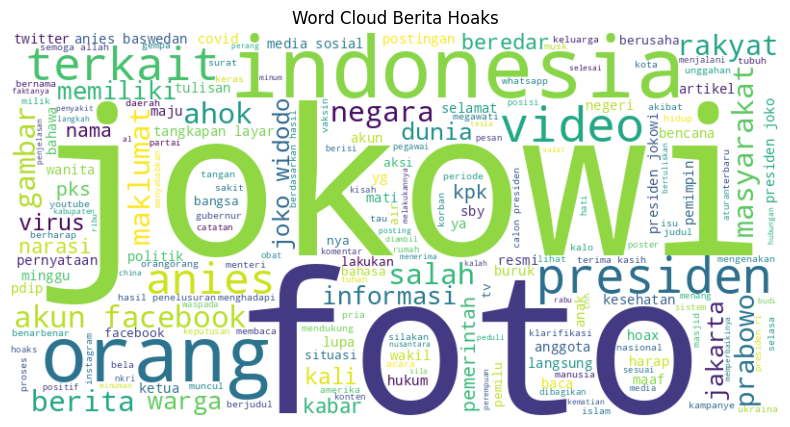

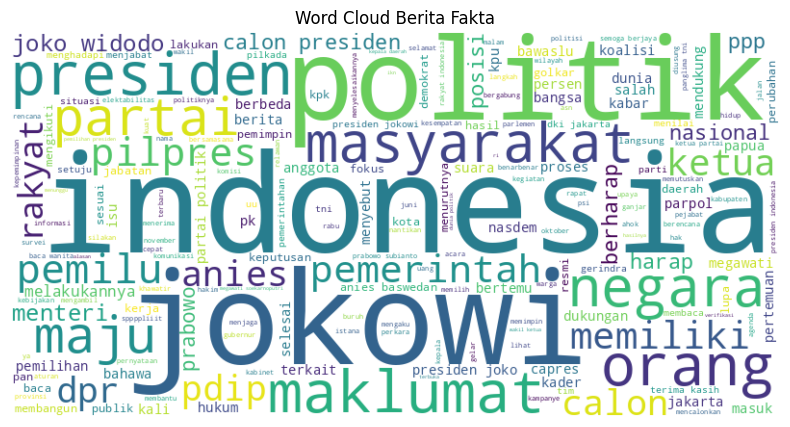

In [ ]:
# Asumsikan 'df' adalah DataFrame dengan kolom 'cleaned' dan 'label'
# di mana 'label' berisi 0 (fakta) atau 1 (hoaks)

# Pisahkan data berita hoaks dan fakta
# Use integer values for filtering
data_hoaks = results_df[results_df['label'] == 1]['cleaned']
data_fakta = results_df[results_df['label'] == 0]['cleaned']

# Gabungkan teks berita hoaks menjadi satu string
teks_hoaks = ' '.join(data_hoaks)
teks_fakta = ' '.join(data_fakta)

# Definisikan stop words bahasa Indonesia
stop_words = set(stopwords.words('indonesian'))

# Buat fungsi untuk menghasilkan word cloud
def buat_wordcloud(cleaned, judul):
    word_tokens = word_tokenize(cleaned)
    filtered_text = [w for w in word_tokens if not w.lower() in stop_words]
    filtered_text = ' '.join(filtered_text)

    # --- HANDLE EMPTY TEXT ---
    if not filtered_text:  # Check if filtered_text is empty
        print(f"Tidak ada teks untuk membuat word cloud untuk '{judul}'.")
        return  # Exit the function if no text is available
    # --- END HANDLE EMPTY TEXT ---

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(judul)
    plt.show()

# Buat word cloud untuk data berita hoaks
buat_wordcloud(teks_hoaks, "Word Cloud Berita Hoaks")

# Buat word cloud untuk data berita fakta
buat_wordcloud(teks_fakta, "Word Cloud Berita Fakta")